# Displacement analysis

Copyright 2021-today Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal**: Learn how to plot and analyse displacement from digital image correlation data (DICe output).

In [1]:
# Import neccesary libraries
import os
import numpy as np
import pandas as pd
from types import SimpleNamespace
from astropy.convolution import Gaussian2DKernel, convolve

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## Step 1: Load the dataset

> For details on the process of reading DICe data and creating efficient Python structures see the notebook [Loading DICe data](https://nbviewer.jupyter.org/github/marcoalopez/Jupyter4DICe/blob/f277d346a009570cf645123dc8fa93f7a0eea4f4/notebooks/LoadingDICe_data.ipynb)

In [2]:
path = 'dataset/'

# loop to extract the data
count = 1
print('Stacking data...')

for filename in os.listdir(path):
    if filename.startswith('DICe') and filename.endswith('.txt'):
        
        # load the corresponding txt file
        df = pd.read_csv(path + filename, delimiter=',')
        
        # separate the different parameters of interest and reorganize them as a matrix
        disp_X = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_X')
        disp_Y = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_Y')
        rot_Z = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='ROTATION_Z')

        
        # generate the numpy arrays
        if count == 1:
            dispX_stack = np.array(disp_X)
            dispY_stack = np.array(disp_Y)
            rotZ_stack = np.array(rot_Z)
            print(f'first processing file: {filename}')
            print('it might take a while...') 
        
        else:
            dispX_stack = np.dstack((dispX_stack, np.array(disp_X)))
            dispY_stack = np.dstack((dispY_stack, np.array(disp_Y)))
            rotZ_stack = np.dstack((rotZ_stack, np.array(rot_Z)))
        count += 1
        print('#', end = '')

print('')
print(f'last processing file: {filename}')
print('Done!')
print(f'Shape of arrays: {dispX_stack.shape}')

data = SimpleNamespace(dispX=dispX_stack,
                       dispY=dispY_stack,
                       rotZ=rotZ_stack)

# remove variables that are not going to be used (to release RAM memory)
del df, count, filename, disp_X, disp_Y, rot_Z, dispX_stack, dispY_stack, rotZ_stack

Stacking data...
first processing file: DICe_solution_000.txt
it might take a while...
##########
last processing file: DICe_solution_074.txt
Done!
Shape of arrays: (377, 189, 10)


Then, let's add a new field to our variable called ``data`` with the magnitude of the displacement. For this we will use the Numpy method ``hypot`` which estimates the hypotenuse, i.e. equivalent to $\sqrt{(dispX^2 + dispY^2)}$.

In [3]:
data.magnitude = np.hypot(data.dispX, data.dispY)
data.magnitude.shape  # check the shape

(377, 189, 10)

In [4]:
np.nanmin(data.dispX[:, :, 9]), np.nanmax(data.dispX[:, :, 9])

(np.float64(-1.6948), np.float64(0.26638))

In [5]:
np.nanmin(data.dispY[:, :, 9]), np.nanmax(data.dispY[:, :, 9])

(np.float64(-0.2418), np.float64(1.9863))

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Marco\AppData\Local\Temp\ipykernel_28048\1650375532.py:16: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Displacement in X ($\mu m$)', fontsize=24)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28048\1650375532.py:20: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Displacement in Y ($\mu m$)', fontsize=24)


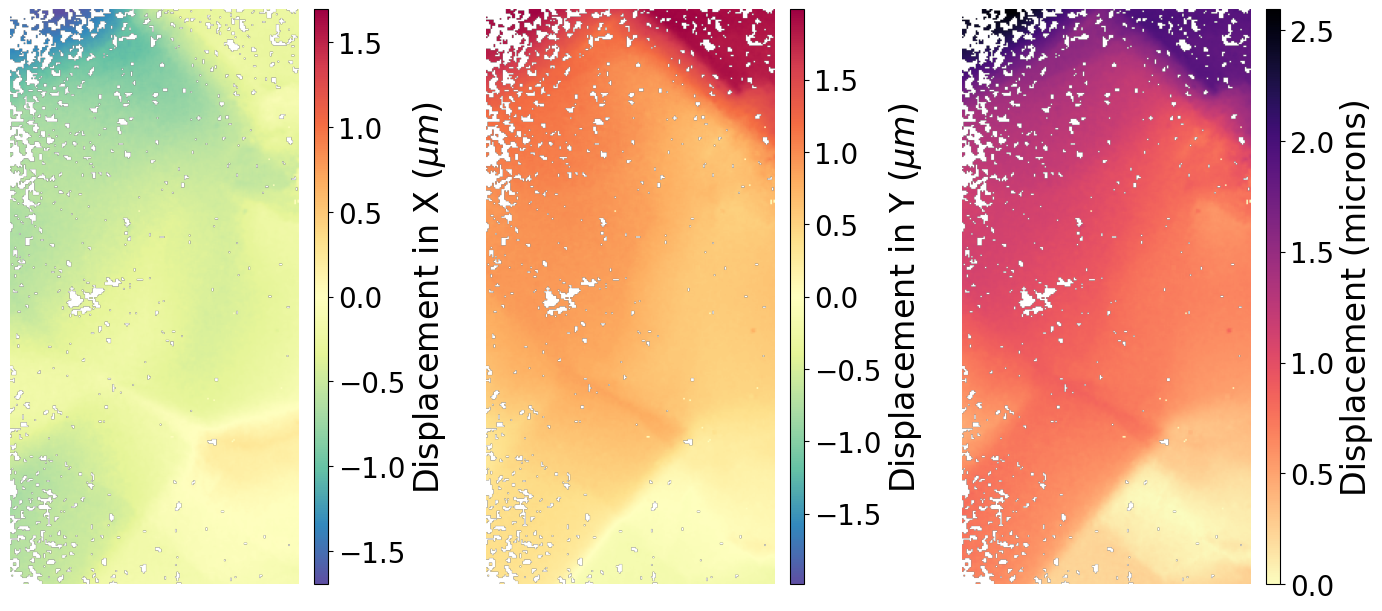

In [6]:
# initialize figure
fig1, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 6), ncols=3, constrained_layout=True)

# set axis off
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# image (take time step 10 --> [:, :, 9])
im1 = ax1.imshow(data.dispX[:, :, 9], vmin=-1.6948, vmax=1.6948, cmap='Spectral_r')
im2 = ax2.imshow(data.dispY[:, :, 9],  vmin=-1.9863, vmax=1.9863, cmap='Spectral_r')
im3 = ax3.imshow(data.magnitude[:, :, 9], cmap='magma_r')

# add a color bars
cbar = fig1.colorbar(im1, ax=ax1, aspect=40)
cbar.set_label('Displacement in X ($\mu m$)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

cbar = fig1.colorbar(im2, ax=ax2, aspect=40)
cbar.set_label('Displacement in Y ($\mu m$)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

cbar = fig1.colorbar(im3, ax=ax3, aspect=40)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

In [7]:
def convolve_over_time(array, std=1.5, size=5):
    """ Using Astropy's Gaussian2DKernel and convolve methods
    it convolves any quantity of interest stored in an 3-dim
    array over time (assuming that time is axis 2). It uses
    a for loop and returns a 3-dim array. This is therefore
    a non optimised ad hoc solution by way of example.
    
    Parameters
    ----------
    array : 3-dim numpy array
        the array containing the quantity of interest
    std : scalar, int or float, optional
        standard deviation of the Gaussian kernel
    size : odd integer
        size of the kernel    
    """
    
    kernel = Gaussian2DKernel(x_stddev=std, x_size=size)
    
    for index in range(array.shape[-1]):
        if index == 0:
            conv_arr_stack = convolve(array[:, :, index], kernel)
        else:
            conv_arr = convolve(array[:, :, index], kernel)
            conv_arr_stack = np.dstack((conv_arr_stack, conv_arr))
    
    np.place(conv_arr_stack, conv_arr_stack == 0.0, np.nan)
    
    return conv_arr_stack

In [8]:
data.conv_dispX = convolve_over_time(data.dispX)
data.conv_dispY = convolve_over_time(data.dispY)
data.conv_rotZ = convolve_over_time(data.rotZ)
data.conv_mag = convolve_over_time(data.magnitude)

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Marco\AppData\Local\Temp\ipykernel_28048\792363320.py:17: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Displacement in X ($\mu m$)', fontsize=24)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28048\792363320.py:21: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Displacement in Y ($\mu m$)', fontsize=24)


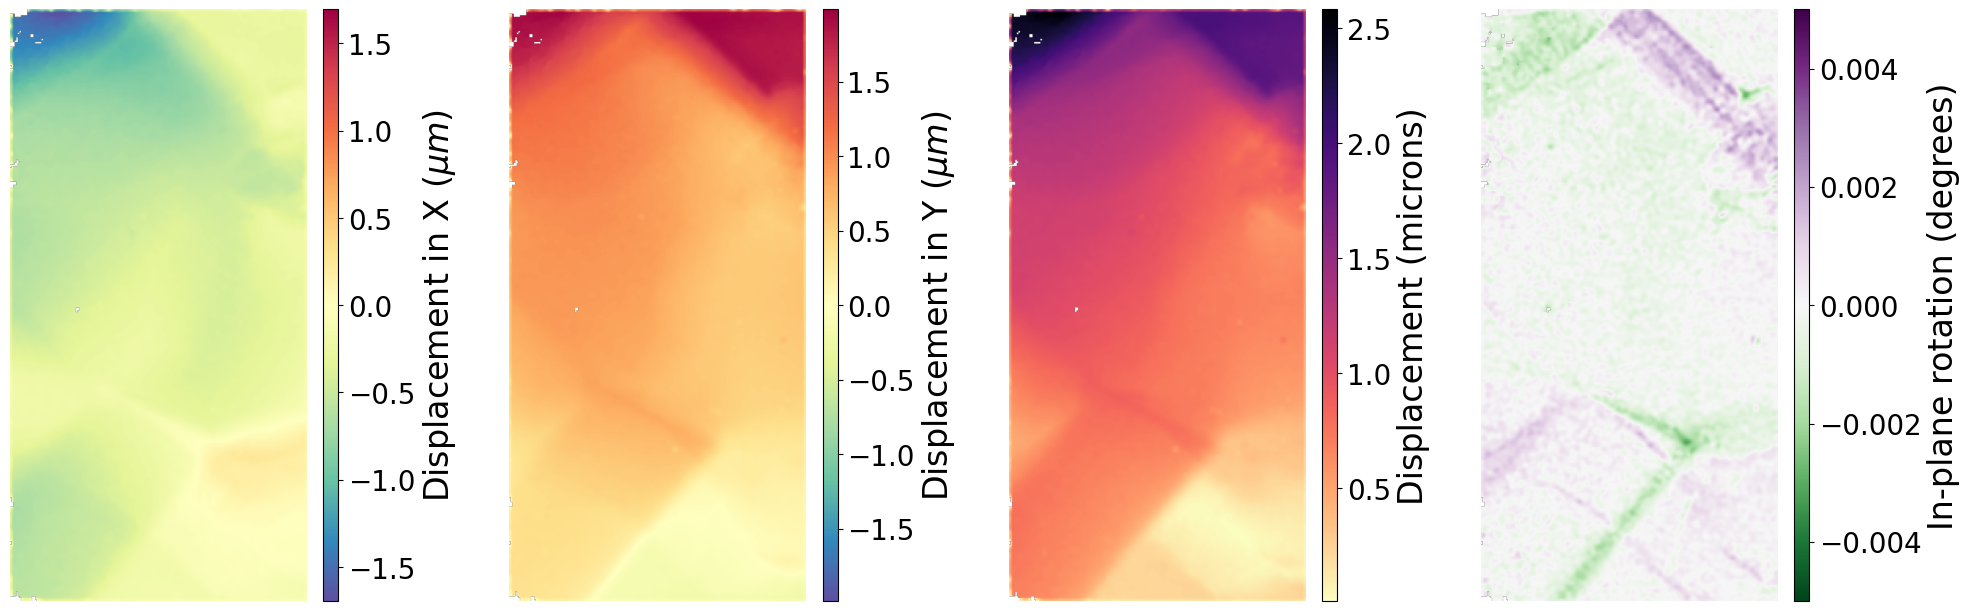

In [9]:
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 6), ncols=4, constrained_layout=True)

# set axis off
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

# image (take time step 10 --> [:, :, 9])
im1 = ax1.imshow(data.conv_dispX[:, :, 9], vmin=-1.6948, vmax=1.6948, cmap='Spectral_r')
im2 = ax2.imshow(data.conv_dispY[:, :, 9],  vmin=-1.9863, vmax=1.9863, cmap='Spectral_r')
im3 = ax3.imshow(data.conv_mag[:, :, 9], cmap='magma_r')
im4 = ax4.imshow(data.conv_rotZ[:, :, 9], vmin=-5e-3, vmax=5e-3, cmap='PRGn_r')

# add a color bars
cbar = fig1.colorbar(im1, ax=ax1, aspect=40)
cbar.set_label('Displacement in X ($\mu m$)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

cbar = fig1.colorbar(im2, ax=ax2, aspect=40)
cbar.set_label('Displacement in Y ($\mu m$)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

cbar = fig1.colorbar(im3, ax=ax3, aspect=40)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

cbar = fig1.colorbar(im4, ax=ax4, aspect=40)
cbar.set_label('In-plane rotation (degrees)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

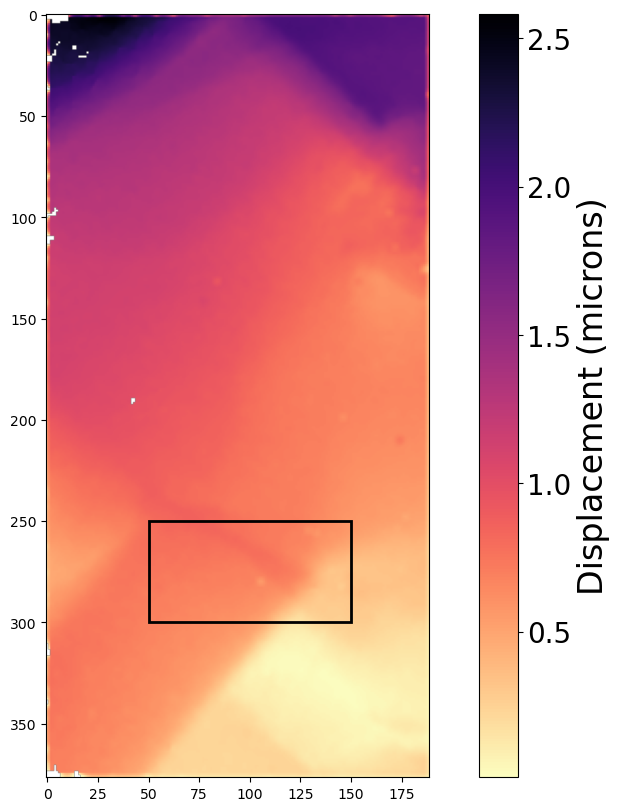

In [10]:
from matplotlib.patches import Rectangle

# initialize figure
figA, ax = plt.subplots(constrained_layout=True)

# image (take time step 10 --> [:, :, 9])
im = ax.imshow(data.conv_mag[:, :, 9], cmap='magma_r')
ax.add_patch(Rectangle(xy=(50, 250), width=100, height=50, fill=None, edgecolor='black', linewidth=2))

# add a color bar
cbar = figA.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

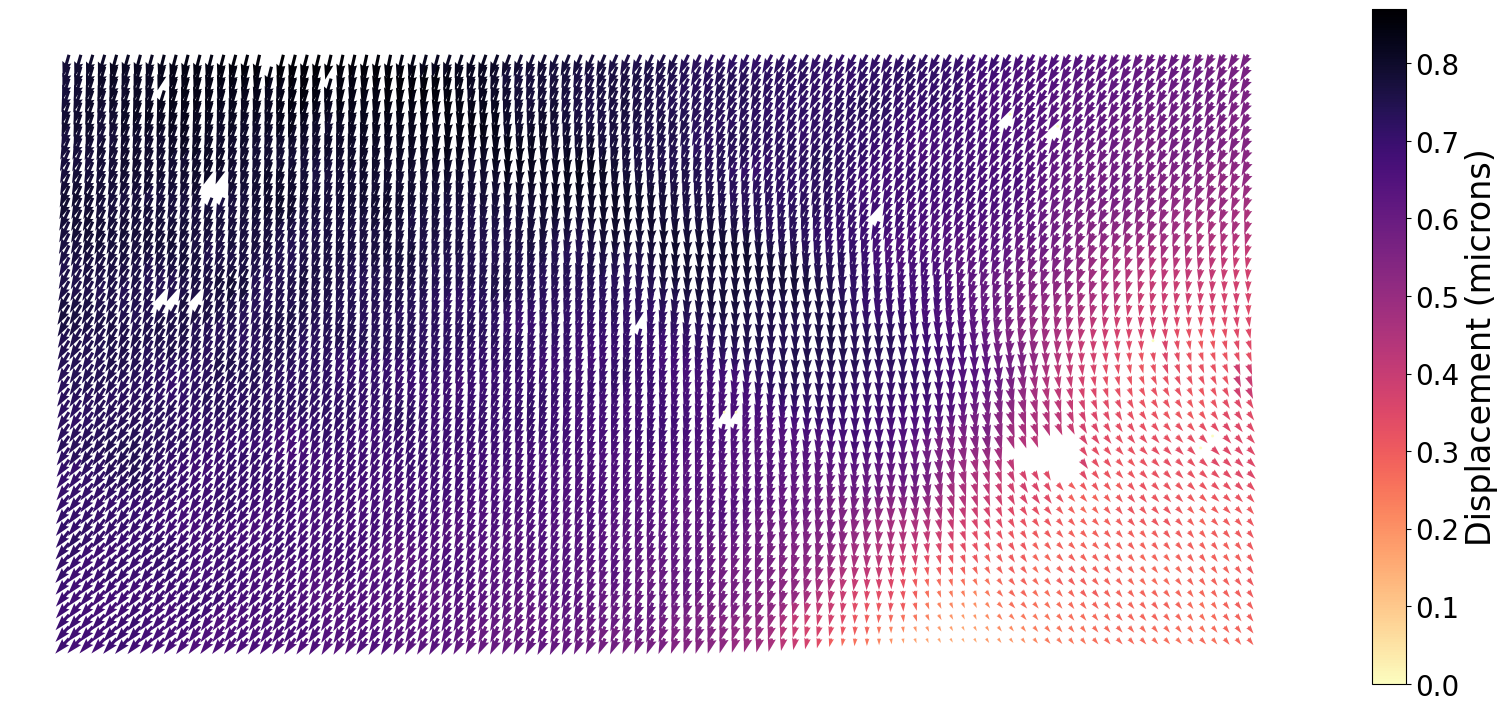

In [11]:
# make...
x, y = np.meshgrid(np.arange(100), np.arange(50))

# initialize figure
fig2, ax = plt.subplots(figsize=(15, 7), constrained_layout=True)

ax.invert_yaxis() # force that y axis increases downwards (as in imshow)
ax.axis('equal') # equal aspect ratio
ax.set_axis_off()

# image (take time step 10 --> [:, :, 9]), note that dispY is multiplied by -1
im = ax.quiver(x, y, data.dispX[250:300, 50:150, 9], data.dispY[250:300, 50:150, 9] * -1, data.magnitude[250:300, 50:150, 9], scale_units='xy', scale=0.4, cmap='magma_r')

# add a color bar
cbar = fig2.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

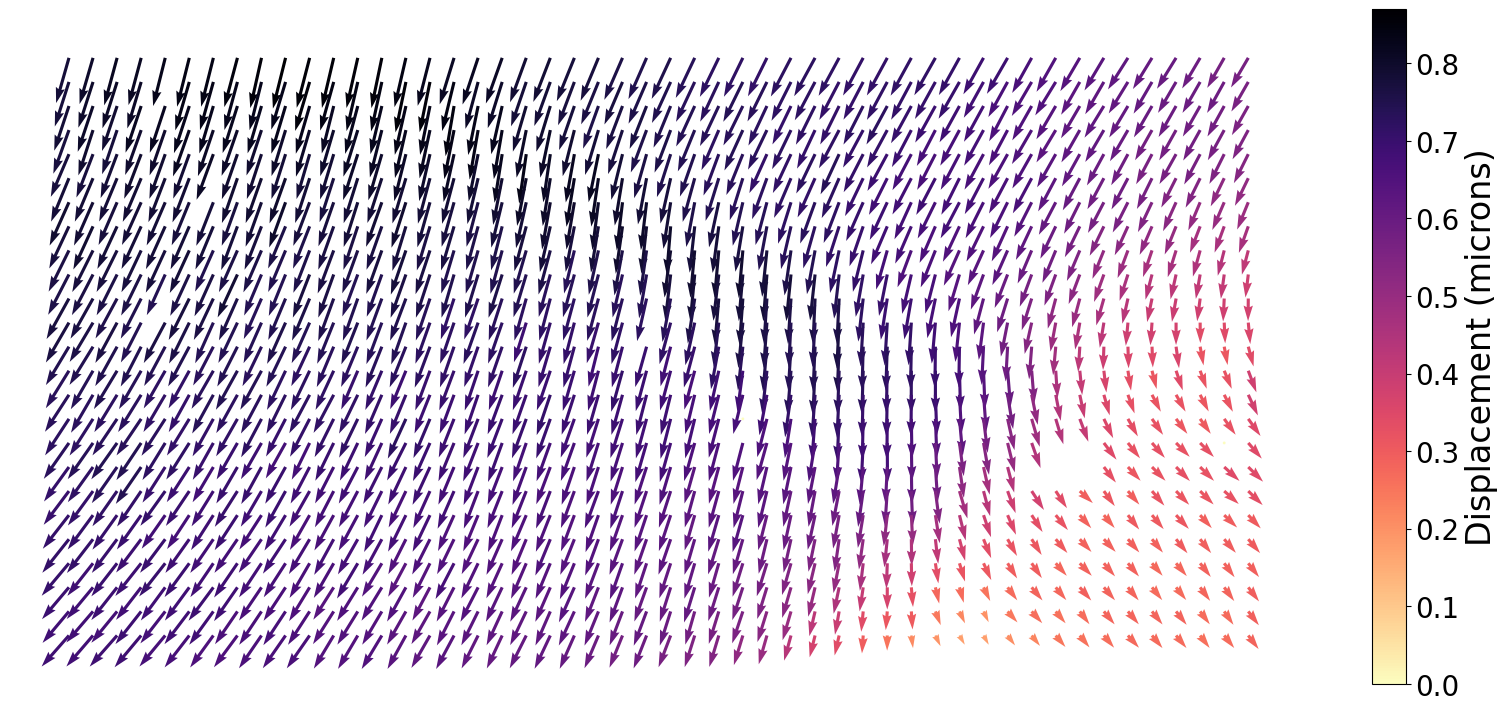

In [12]:
# decrease vector density (i.e. downsample) for clarity
x2, y2 = np.meshgrid(np.arange(50), np.arange(25))

fig3, ax = plt.subplots(figsize=(15, 7), constrained_layout=True)

ax.invert_yaxis() # force that y axis increases downwards (as in imshow)
ax.axis('equal') # equal aspect ratio
ax.set_axis_off()

# image (take time step 10 --> [:, :, 9]), note that dispY is multiplied by -1
im = ax.quiver(x2, y2, data.dispX[250:300:2, 50:150:2, 9], data.dispY[250:300:2, 50:150:2, 9] * -1, data.magnitude[250:300:2, 50:150:2, 9], scale_units='xy', scale=0.4, cmap='magma_r')

# add a color bar
cbar = fig3.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

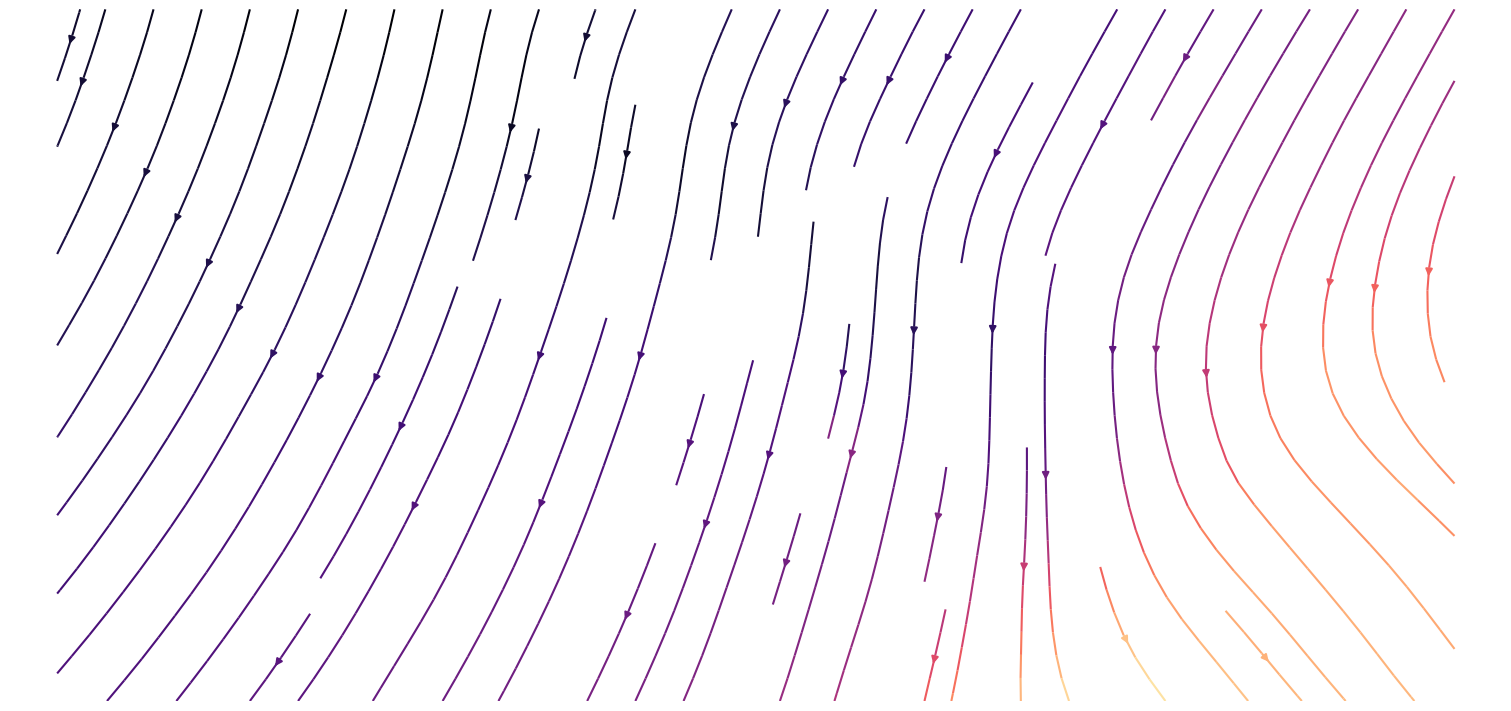

In [13]:
# initialize figure
fig4, ax = plt.subplots(figsize=(15, 7), constrained_layout=True)

ax.invert_yaxis() # force that y axis increases downwards (as in imshow)
ax.axis('equal') # equal aspect ratio
ax.set_axis_off()

# image (take time step 10 --> [:, :, 9])
im = ax.streamplot(x, y, data.conv_dispX[250:300, 50:150, 9], data.conv_dispY[250:300, 50:150, 9], color=data.conv_mag[250:300, 50:150, 9], cmap='magma_r')

# add a color bar
#cbar = fig4.colorbar(im, ax=ax)
#cbar.set_label('Displacement (microns)', fontsize=24)
#cbar.ax.tick_params(labelsize=20)

In [14]:
import sys
import matplotlib as mpl
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)

Notebook tested in 2025-02-26 using:
Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Numpy 2.2.2
Pandas 2.2.3
Matplotlib 3.10.0
